# Supreme Court Judgement Prediction 

The dataset contains 3304 cases from the Supreme Court of the United States from 1955 to 2021. Each case has the case's identifiers as well as the facts of the case and the decision outcome. Other related datasets rarely included the facts of the case which could prove to be helpful in natural language processing applications. One potential use case of this dataset is determining the outcome of a case using its facts.

Target Variable: First Party Winner, if true means that the first party won, and if false it means that the second party won.

Acknowledgements : 

Mohammad Alali, Shaayan Syed, Mohammed Alsayed, Smit Patel, Hemanth Bodala

## Reference for this dataset 
https://www.kaggle.com/datasets/deepcontractor/supreme-court-judgment-prediction/data

# 1. Importing libraries that are planned to be used in our process

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
## for data
import pandas as pd

import re
import nltk## for language detection
import os


## 2. Reading the dataset with pandas, dropping null values (calculated earlier at less than 5%) and creating a copy of the dataframe for the modelling process

In [3]:
df = pd.read_csv(r"C:\Users\Ninad gajbhiye\Desktop\Capstone Project 2\archive (5)\justice.csv",delimiter=',')

In [4]:
df.head()

,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
0,0,50606,Roe v. Wade,https://api.oyez.org/cases/1971/70-18,70-18,1971,Jane Roe,Henry Wade,"<p>In 1970, Jane Roe (a fictional name used in...",501,7,2,True,majority opinion,reversed,NaN
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment


In [5]:
df.isnull().sum()[df.isnull().sum()>0]

first_party             1
second_party            1
first_party_winner     15
decision_type           7
disposition            72
issue_area            142
dtype: int64

In [6]:
df.shape 

(3303, 16)

Since Nulls present on this data set  are less than 5% ill drop those 

In [7]:
df = df.dropna()

In [8]:
df.isnull().sum()[df.isnull().sum()>0]

Series([], dtype: int64)

In [9]:
df1 = df.copy()

In [10]:
df1.drop(columns=['Unnamed: 0', 'docket','name','first_party','second_party', 'issue_area', 
                 'facts_len', 'majority_vote', 'minority_vote', 'href', 'ID','term'], inplace=True)

## 3.Seperating the dataset into target variables and two groups of independent variables, one (df_cat) which requires one-hot encoding to be machine readable and the other (df_nlp) which is t|ext data which needs to be cleaned for features to be engineered from it.

In [11]:
df_cat = df1[['decision_type', 'disposition']]

In [12]:
df_target = df1['first_party_winner']

In [13]:
df_facts = df1['facts']

## 4. Resetting indices to avoid NaNs during concatenation and performing one-hot encoding

In [14]:
df_cat.reset_index(drop=True, inplace=True)
df_target.reset_index(drop=True, inplace=True)
df_facts.reset_index(drop=True, inplace=True)

In [15]:
df_facts

0       <p>Joan Stanley had three children with Peter ...
1       <p>John Giglio was convicted of passing forged...
2       <p>The Idaho Probate Code specified that "male...
3       <p>Miller, after conducting a mass mailing cam...
4       <p>Ernest E. Mandel was a Belgian professional...
                              ...                        
3093    <p>For over a century after the Alaska Purchas...
3094    <p>Refugio Palomar-Santiago, a Mexican nationa...
3095    <p>Tarahrick Terry pleaded guilty to one count...
3096    <p>Joshua James Cooley was parked in his picku...
3097    <p>The Natural Gas Act (NGA), 15 U.S.C. §§ 717...
Name: facts, Length: 3098, dtype: object

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_target = le.fit_transform(df_target)

In [17]:
df_target

array([1, 1, 1, ..., 0, 1, 1])

In [18]:
df_target1 = pd.DataFrame(df_target,columns=['first_party_winner'])

In [19]:
df_target1

,first_party_winner
0,1
1,1
2,1
3,1
4,1
...,...
3093,1
3094,1
3095,0
3096,1


In [20]:
frames = [df_cat, df_target1]
df2 = pd.concat(frames, axis=1, join='inner')
df2

,decision_type,disposition,first_party_winner
0,majority opinion,reversed/remanded,1
1,majority opinion,reversed/remanded,1
2,majority opinion,reversed/remanded,1
3,majority opinion,vacated/remanded,1
4,majority opinion,reversed,1
...,...,...,...
3093,majority opinion,reversed/remanded,1
3094,majority opinion,reversed/remanded,1
3095,majority opinion,affirmed,0
3096,majority opinion,vacated/remanded,1


In [21]:
df_fact1 = pd.DataFrame(df_facts,columns=['facts'])

In [22]:
df_fact1

,facts
0,<p>Joan Stanley had three children with Peter ...
1,<p>John Giglio was convicted of passing forged...
2,"<p>The Idaho Probate Code specified that ""male..."
3,"<p>Miller, after conducting a mass mailing cam..."
4,<p>Ernest E. Mandel was a Belgian professional...
...,...
3093,<p>For over a century after the Alaska Purchas...
3094,"<p>Refugio Palomar-Santiago, a Mexican nationa..."
3095,<p>Tarahrick Terry pleaded guilty to one count...
3096,<p>Joshua James Cooley was parked in his picku...


In [23]:
df_fact1['facts']= df_fact1['facts'].str.replace(r'<[^<>]*>', '',regex=True)

In [24]:
df_fact1

,facts
0,Joan Stanley had three children with Peter Sta...
1,John Giglio was convicted of passing forged mo...
2,"The Idaho Probate Code specified that ""males m..."
3,"Miller, after conducting a mass mailing campai..."
4,Ernest E. Mandel was a Belgian professional jo...
...,...
3093,For over a century after the Alaska Purchase i...
3094,"Refugio Palomar-Santiago, a Mexican national, ..."
3095,Tarahrick Terry pleaded guilty to one count of...
3096,Joshua James Cooley was parked in his pickup t...


## 5.Performing initial cleaning and tokenizing the corpus, introducing a function to perform further cleaning and Lemmatization upon the data.

In [25]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to C:\Users\Ninad
[nltk_data]     gajbhiye\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
corpus = df_fact1["facts"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))

In [27]:
ps = nltk.stem.porter.PorterStemmer()
lem = nltk.stem.wordnet.WordNetLemmatizer()

In [28]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [29]:
df_fact1['facts_preprocessed'] = df_fact1['facts'].apply(utils_preprocess_text)

In [30]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to C:\Users\Ninad
[nltk_data]     gajbhiye\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [31]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Ninad
[nltk_data]     gajbhiye\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [32]:
df_fact1

,facts,facts_preprocessed
0,Joan Stanley had three children with Peter Sta...,joan stanley had three child with peter stanle...
1,John Giglio was convicted of passing forged mo...,john giglio wa convicted of passing forged mon...
2,"The Idaho Probate Code specified that ""males m...",the idaho probate code specified that male mus...
3,"Miller, after conducting a mass mailing campai...",miller after conducting a mass mailing campaig...
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel wa a belgian professional jour...
...,...,...
3093,For over a century after the Alaska Purchase i...,for over a century after the alaska purchase i...
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago a mexican national wa ...
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty to one count of...
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley wa parked in his pickup tr...


## EDA 

In [33]:
df_fact2 = pd.concat([df_fact1,df_target1['first_party_winner']],axis=1, join='inner')

In [34]:
df_fact2.first_party_winner.value_counts()

1    2067
0    1031
Name: first_party_winner, dtype: int64

In [35]:
df_fact2

,facts,facts_preprocessed,first_party_winner
0,Joan Stanley had three children with Peter Sta...,joan stanley had three child with peter stanle...,1
1,John Giglio was convicted of passing forged mo...,john giglio wa convicted of passing forged mon...,1
2,"The Idaho Probate Code specified that ""males m...",the idaho probate code specified that male mus...,1
3,"Miller, after conducting a mass mailing campai...",miller after conducting a mass mailing campaig...,1
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel wa a belgian professional jour...,1
...,...,...,...
3093,For over a century after the Alaska Purchase i...,for over a century after the alaska purchase i...,1
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago a mexican national wa ...,1
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty to one count of...,0
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley wa parked in his pickup tr...,1


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.pyplot import figure
import wordcloud

In [37]:
y=0
corpus = df_fact2[df_fact2['first_party_winner']==y]['facts_preprocessed']

In [38]:
corpus

6       william baird gave away emko vaginal foam to a...
7       a georgia state court convicted johnny wilson ...
10      after observing and interviewing a number of p...
11      william shard reported to the chicago police t...
12      jonas yoder and wallace miller both member of ...
                              ...                        
3085    bl a student at mahanoy area high school mahs ...
3086    in 2007 tracy a greer pleaded guilty to one co...
3088    petitioner jose sanchez and his wife were citi...
3089    in 2006 the city of san antonio texas filed a ...
3095    tarahrick terry pleaded guilty to one count of...
Name: facts_preprocessed, Length: 1031, dtype: object

In [39]:
from wordcloud import WordCloud
from nltk.corpus import stopwords

Text(0.5, 1.0, 'Most Appeared Words')

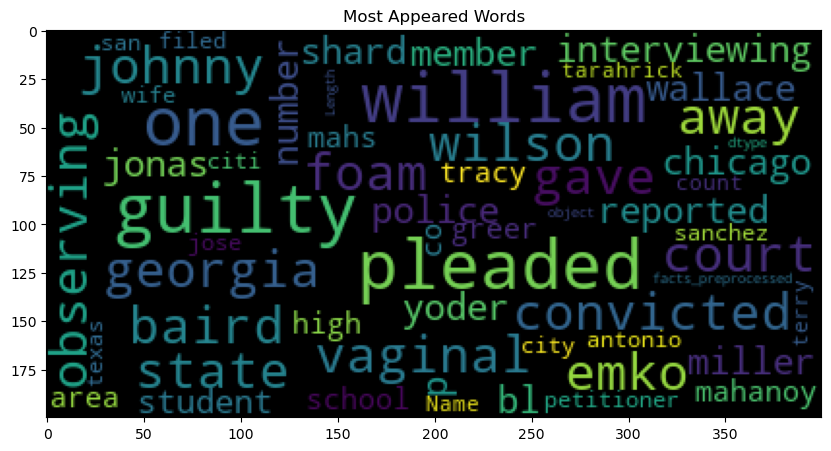

In [40]:
cloud = WordCloud(stopwords=stopwords.words('english'),max_words=100,max_font_size=35).generate(str(corpus))
plt.figure(figsize=(10,10))
plt.imshow(cloud)
plt.title('Most Appeared Words')

In [41]:
df_cat

,decision_type,disposition
0,majority opinion,reversed/remanded
1,majority opinion,reversed/remanded
2,majority opinion,reversed/remanded
3,majority opinion,vacated/remanded
4,majority opinion,reversed
...,...,...
3093,majority opinion,reversed/remanded
3094,majority opinion,reversed/remanded
3095,majority opinion,affirmed
3096,majority opinion,vacated/remanded


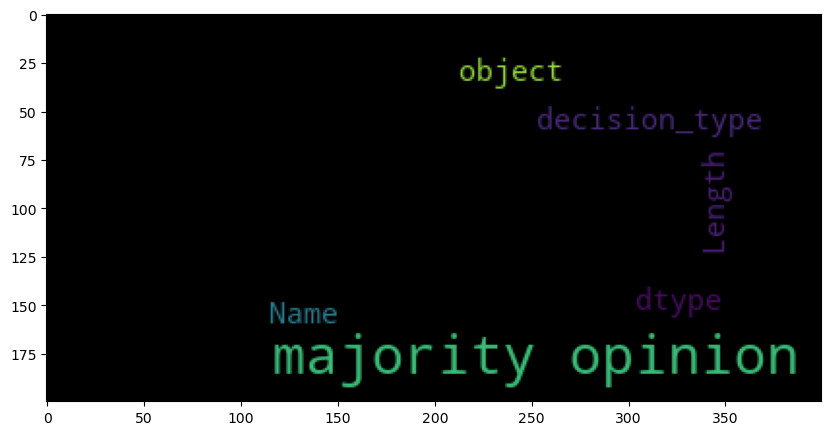

In [42]:
cloud = WordCloud(stopwords=stopwords.words('english'),max_words=15).generate(str(df_cat['decision_type']))
plt.figure(figsize=(10,10))
plt.imshow(cloud)

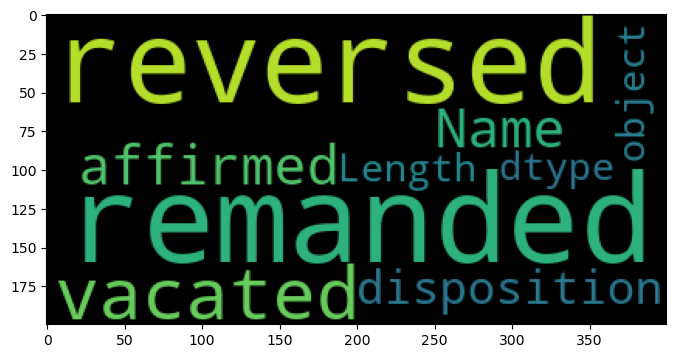

In [85]:
cloud = WordCloud(stopwords=stopwords.words('english'),max_words=15).generate(str(df_cat['disposition']))
plt.figure(figsize=(8,10))
plt.imshow(cloud);

## 7. Introducing Count Vectorizer to derive features from textual data.

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

In [45]:
vectorizer = CountVectorizer()

In [46]:
x = df_fact2['facts_preprocessed']
y = df_fact2['first_party_winner']

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
x_train , x_test , y_train , y_test = train_test_split(x,y, test_size=0.2)

In [50]:
df_transformer = CountVectorizer(analyzer=utils_preprocess_text).fit(df_fact2.facts_preprocessed)

In [51]:
df_transformer.vocabulary_

{'j': 21,
 'o': 26,
 'a': 12,
 'n': 25,
 ' ': 0,
 's': 30,
 't': 31,
 'l': 23,
 'e': 16,
 'y': 36,
 'h': 19,
 'd': 15,
 'r': 29,
 'c': 14,
 'i': 20,
 'w': 34,
 'p': 27,
 'v': 33,
 'm': 24,
 'b': 13,
 'u': 32,
 'g': 18,
 'f': 17,
 '1': 2,
 '8': 9,
 'k': 22,
 'q': 28,
 'x': 35,
 '9': 10,
 '6': 7,
 '2': 3,
 '5': 6,
 '3': 4,
 '7': 8,
 '0': 1,
 'z': 37,
 '4': 5,
 '_': 11,
 'é': 40,
 '½': 38,
 'ó': 42,
 'í': 41,
 'á': 39,
 'ü': 43}

In [52]:
tdm = df_transformer.transform(df_fact2.facts_preprocessed)

In [53]:
tdm

<3098x44 sparse matrix of type '<class 'numpy.int64'>'
	with 88645 stored elements in Compressed Sparse Row format>

In [54]:
tdm.shape

(3098, 44)

In [55]:
x_train_tdm , x_test_tdm , y_train_tdm , y_test_tdm = train_test_split(tdm, df_fact2.first_party_winner,test_size=0.2)

In [56]:
x_train_tdm.shape

(2478, 44)

In [57]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(x_train_tdm,y_train_tdm)

MultinomialNB()

In [58]:
pred_nb = nb.predict(x_test_tdm)

In [59]:
from sklearn.metrics import confusion_matrix

In [60]:
tab_nb  = confusion_matrix(y_test_tdm,pred_nb)

In [61]:
tab_nb

array([[ 47, 155],
       [ 92, 326]], dtype=int64)

In [62]:
tab_nb.diagonal().sum()/tab_nb.sum()

0.6016129032258064

In [63]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train_tdm,y_train_tdm)

DecisionTreeClassifier()

In [64]:
pred_dt = dt.predict(x_test_tdm)

In [65]:
tab_dt = confusion_matrix(y_test_tdm,pred_dt)
tab_dt

array([[ 76, 126],
       [143, 275]], dtype=int64)

In [66]:
tab_nb.diagonal().sum()/tab_nb.sum()

0.6016129032258064

In [67]:

from tensorflow.keras.utils       import to_categorical
#necessary imports 
from keras.preprocessing.text     import Tokenizer # assign number to each word
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Embedding
from keras.layers import Dense, LSTM

In [68]:
y_train = to_categorical(y_train)

In [69]:
y_train.shape

(2478, 2)

In [70]:
max_num_words = 10000 # total how many words to be consodered from the corpus (collection of document)
seq_len = 50  # how many words to be taken from each word
embedding_size = 100 #vector length (embedding size) for each word

In [71]:
tokenizer = Tokenizer(num_words= max_num_words)
tokenizer.fit_on_texts(df_fact2.facts_preprocessed)
x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train , maxlen=seq_len)

In [72]:
model = Sequential() #initializing the model 
model.add(Embedding ( input_dim    = max_num_words , 
                      input_length = seq_len       ,
                      output_dim   = embedding_size))

model.add(LSTM(5))
model.add(Dense(2 , activation='softmax')) #final layer


from tensorflow.keras.optimizers import Adam

adam  = Adam(lr = 0.001)

model.compile(optimizer = adam ,loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [73]:
x_train.shape

(2478, 50)

In [74]:
model.fit(x_train,y_train ,epochs=10,batch_size=32 , validation_split = 0.2)

Epoch 1/10
62/62 [==============================] - 3s 24ms/step - loss: 0.6595 - accuracy: 0.6524 - val_loss: 0.6323 - val_accuracy: 0.6734
Epoch 2/10
62/62 [==============================] - 1s 18ms/step - loss: 0.6088 - accuracy: 0.6630 - val_loss: 0.6314 - val_accuracy: 0.6754
Epoch 3/10
62/62 [==============================] - 1s 18ms/step - loss: 0.5258 - accuracy: 0.7099 - val_loss: 0.6545 - val_accuracy: 0.6411
Epoch 4/10
62/62 [==============================] - 1s 18ms/step - loss: 0.3942 - accuracy: 0.8512 - val_loss: 0.7509 - val_accuracy: 0.6210
Epoch 5/10
62/62 [==============================] - 1s 18ms/step - loss: 0.2621 - accuracy: 0.9339 - val_loss: 0.8664 - val_accuracy: 0.6310
Epoch 6/10
62/62 [==============================] - 1s 19ms/step - loss: 0.1869 - accuracy: 0.9536 - val_loss: 0.9643 - val_accuracy: 0.5968
Epoch 7/10
62/62 [==============================] - 1s 17ms/step - loss: 0.1389 - accuracy: 0.9702 - val_loss: 1.0266 - val_accuracy: 0.5565
Epoch 8/10
62

In [75]:
x_test = tokenizer.texts_to_sequences(x_test)

In [76]:
x_test = pad_sequences(x_test , maxlen=seq_len)

In [77]:
x_test

array([[1777,    4,  426, ...,    5,    1,  192],
       [  95,    2,    1, ...,  324,   21,  188],
       [   0,    0,    0, ...,    3, 4620,  361],
       ...,
       [8204,    5, 8206, ...,   43,    1,   64],
       [  22, 5794,   39, ..., 6293, 2294, 2486],
       [   2, 5799,  324, ...,  160,    7,  191]])

In [78]:
pred_model = model.predict(x_test)

20/20 [==============================] - 0s 3ms/step


In [79]:
pred_class = pred_model.argmax(axis=1)

In [80]:
from sklearn.metrics import confusion_matrix

In [81]:
tab_lstm = confusion_matrix(y_test , pred_class)

In [82]:
tab_lstm

array([[ 54, 146],
       [113, 307]], dtype=int64)

In [83]:
df_fact2.first_party_winner.value_counts()

1    2067
0    1031
Name: first_party_winner, dtype: int64

In [84]:
df_fact2

,facts,facts_preprocessed,first_party_winner
0,Joan Stanley had three children with Peter Sta...,joan stanley had three child with peter stanle...,1
1,John Giglio was convicted of passing forged mo...,john giglio wa convicted of passing forged mon...,1
2,"The Idaho Probate Code specified that ""males m...",the idaho probate code specified that male mus...,1
3,"Miller, after conducting a mass mailing campai...",miller after conducting a mass mailing campaig...,1
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel wa a belgian professional jour...,1
...,...,...,...
3093,For over a century after the Alaska Purchase i...,for over a century after the alaska purchase i...,1
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago a mexican national wa ...,1
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty to one count of...,0
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley wa parked in his pickup tr...,1
